<a href="https://colab.research.google.com/github/marlonrcfranco/weather-guru/blob/main/weather_guru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# weather-guru
## Will it rain tomorrow?


### Goal 🌦
Implement an algorithm that performs **next day rain prediction** by training machine learning models on the target variable `RainTomorrow`.



### Dataset 📂
The dataset contains about **10 years of daily weather observations** from various locations in **Australia**.

**`RainTomorrow`** is the target variable to be  predicted. It means - it rained the next day, this column is `Yes` if the rain that day was 1mm or more.







## Imports & Defines

In [ ]:
%matplotlib inline
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from functools import partial
import plotly.express as px
!pip install portolan
import portolan

# Defines
DATASET_URL = "https://raw.githubusercontent.com/marlonrcfranco/weather-guru/main/data/weatherAUS.csv"
TARGET_NAME = 'RainTomorrow'

EPOCHS = 100
# The number of epochs is the number of complete passes through the training dataset. 
# The number 100 is arbitrary, chosen to improve the model accuracy and training time.

BATCH_SIZE = 1023
# The size of a batch must be more than or equal to one and less than or equal to the number of samples in the training dataset.
# The number 1023 is also arbitrary, chosen to improve the model accuracy and training time.

K_FOLD_SPLITS = 5
# The number of iterations used in the cross validation. 
# The number 5 is arbitrary, chosen to reduce the time the validation takes.

LOSS_FUNCTION = 'binary_crossentropy'
# Binary cross entropy compares each of the predicted probabilities to actual class output which can be either 0 or 1. 
# The loss function 'binary_crossentropy' was chosen since the target variable is binary.

LEARNING_RATE = 0.001
# Learning rate used in the Adam optimizer. 
# The value of 0.001 is arbitrary, chosen by trial and error, evaluating the model's improvements.

NEURONS_1 = 27
# The number of neurons in the first hidden layer. 
# The values 27 is arbitrary, chosen by trial and error, evaluating the model's improvements.

NEURONS_2 = 7
# The number of neurons in the first hidden layer. 
# The values 7 was chosen to 'force' the model to choose the most relevant features



## Fetch Data

In [ ]:
weather_df = pd.read_csv(DATASET_URL,parse_dates=True)
weather_df.shape

(145460, 23)

## Data Preprocessing

### Dataframe Info

In [ ]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

### Sample

In [ ]:
weather_df.sample()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
57625,2016-01-26,Ballarat,13.5,27.4,0.0,NaN,NaN,SE,57.0,SE,SE,43.0,22.0,71.0,33.0,1016.9,1014.8,NaN,3.0,18.0,26.2,No,No


### Unique values for non-numeric columns

There are some 'string' values in the dataset. Let's see what these values are.

In [ ]:
for col in weather_df:
  if not pd.api.types.is_numeric_dtype(weather_df[col]):
    print("\n-------\nColumn: "+col+" ["+str(len(weather_df[col].unique()))+" unique values]:\n")
    print(weather_df[col].unique())


-------
Column: Date [3436 unique values]:

['2008-12-01' '2008-12-02' '2008-12-03' ... '2008-01-29' '2008-01-30'
 '2008-01-31']

-------
Column: Location [49 unique values]:

['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']

-------
Column: WindGustDir [17 unique values]:

['W' 'WNW' 'WSW' 'NE' 'NNW' 'N' 'NNE' 'SW' nan 'ENE' 'SSE' 'S' 'NW' 'SE'
 'ESE' 'E' 'SSW']

-------
Column: WindDir9am [17 unique values]:

['W' 'NNW' 'SE' 'ENE' 'SW' 'SSE' 'S' 'NE' nan 'SSW' 

So there are 3436 days of observation in the dataset.

### Check for duplicated rows

In [ ]:
# Check if exists duplicated rows based on all columns
duplicateRowsDF = weather_df[weather_df.duplicated()]
if len(duplicateRowsDF)!=0: print("Identical rows were found!")

# Check if exists is duplicated rows based on 'Date' column
duplicateRowsDF = weather_df[weather_df.duplicated(['Date'])]
if len(duplicateRowsDF)!=0: 
  print(len(duplicateRowsDF),"rows with the same Date were found.\n")

# Check if exists is duplicated rows based on 'Date' and 'Location' columns
duplicateRowsDF = weather_df[weather_df.duplicated(['Date','Location'])]
if len(duplicateRowsDF)!=0: 
  print(len(duplicateRowsDF),"rows with the same Date and Location were found.\n")

142024 rows with the same Date were found.



### Convert Date to datetime

Since we have a column called 'Date' in a date-like format, let's convert it to datetime.

In [ ]:
weather_df['Date'] = pd.to_datetime(weather_df['Date'])

#### Wind Cardinal directions (string) to Degrees (float)

Wind directions are represented in Cardinal directions (e.g. N, S, SW,...). In order to make the dataset only with numbers, let's convert these directions into angles (degrees).

In [ ]:
weather_df[['WindGustDir','WindDir9am','WindDir3pm']].head(1)

,WindGustDir,WindDir9am,WindDir3pm
0,W,W,WNW


In [ ]:
weather_df['WindGustDir'] = weather_df['WindGustDir'].apply(lambda w: portolan.middle(str(w)) if str(w)!='nan' else w)
weather_df['WindDir9am'] = weather_df['WindDir9am'].apply(lambda w: portolan.middle(str(w)) if str(w)!='nan' else w)
weather_df['WindDir3pm'] = weather_df['WindDir3pm'].apply(lambda w: portolan.middle(str(w)) if str(w)!='nan' else w)

In [ ]:
weather_df[['WindGustDir','WindDir9am','WindDir3pm']].head(1)

,WindGustDir,WindDir9am,WindDir3pm
0,270.0,270.0,292.5


### Map 'Yes' and 'No' to infer boolean values


In [ ]:
weather_df.RainToday = weather_df.RainToday.map(dict(Yes=1, No=0))
weather_df.RainTomorrow = weather_df.RainTomorrow.map(dict(Yes=1, No=0))

### Add YEAR, MONTH and DAY columns

In [ ]:
weather_df['year'] = weather_df.Date.dt.year
weather_df['month'] = weather_df.Date.dt.month
weather_df['day'] = weather_df.Date.dt.day

# Drop the Date column
# It is now replaced by year, month and day columns
weather_df.drop(['Date'], axis=1, inplace=True)

### Add latitude and longitude columns

In order to catch cyclic behaviors, we can feed the model with the day, month and year separately and allow it to perceive patterns related to seasons, for example.

In [ ]:
locator = Nominatim(user_agent="weather-guru")
# conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

# 1 - List the unique values of Location, to further improve performance
unique_locations = pd.DataFrame()
unique_locations['description'] = weather_df['Location'].unique()
unique_locations['id'] = weather_df['Location'].unique()
unique_locations.set_index(['id'], inplace = True)
print("Total unique locations: {}".format(len(unique_locations)))

# Add 'rainfall/day' column
unique_locations['days'] = weather_df['Location'].value_counts().values
unique_locations['rainfall'] = weather_df.groupby(['Location']).sum()['Rainfall'].values
unique_locations['rainfall/day'] = unique_locations['rainfall']/unique_locations['days']

# Separate CamelCase with space to allow geocode to find the location
unique_locations['description'] = unique_locations['description'].apply(lambda loc: re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', loc)))
# Add the country to the Location in order to avoid misunderstandings
unique_locations['description'] = unique_locations['description'].apply(lambda loc: loc + ', Australia')

# 2- create improved location column (gcode)
print("Searching for locations...")
unique_locations['gcode'] =  unique_locations['description'].apply(partial(geocode, addressdetails=True))

# 3 - create point (longitude, latitude and altitude) from gcode (location) column (returns tuple)
unique_locations['point'] = unique_locations['gcode'].apply(lambda loc: tuple(loc.point) if loc else None)

# 4 - split point column into latitude, longitude and altitude columns
unique_locations[['latitude', 'longitude', 'altitude']] = pd.DataFrame(unique_locations['point'].tolist(), index=unique_locations.index)

# Verify if all the locations were found
if not unique_locations['gcode'].isnull().any(): 
  print("All the locations were found!")
else: 
  print("The current locations were not found:")
  print(unique_locations[unique_locations['gcode'].isnull()])

# Verify if all the found locations are from Australia
unique_locations['country'] = unique_locations['gcode'].apply(lambda loc: (loc.raw.get('address').get('country')) if loc else None)
if unique_locations['country'].str.contains('Australia').all():
  print("All the found locations are from Australia")

def get_lat_lon_alt_from_location(location_name):
  location_data = unique_locations.loc[location_name]
  lat = location_data['latitude']
  lon = location_data['longitude']
  alt = location_data['altitude']
  return lat,lon,alt

print("Adding latitude, longitude and altitude columns to the dataset...")
weather_df[['latitude', 'longitude', 'altitude']] = list(weather_df['Location'].apply(get_lat_lon_alt_from_location))

# Drop the Location column
# It is now replaced by latitude, longitude and altitude columns
weather_df.drop(['Location'], axis=1, inplace=True)


Total unique locations: 49
Searching for locations...
All the locations were found!
All the found locations are from Australia
Adding latitude, longitude and altitude columns to the dataset...


In [ ]:
weather_df.altitude.unique()

array([0.])

The `altitude` column is 0 for all the observations, so we can remove it from the dataset.

In [ ]:
weather_df.drop('altitude',axis=1,inplace=True)

### Plot map (just for fun)

In [ ]:
# Plot map
fig = px.scatter_geo(unique_locations,lat='latitude',lon='longitude', hover_name="description", color='rainfall/day')
fig.update_layout(title = 'Locations in the dataset', title_x=0.5)
fig.show()

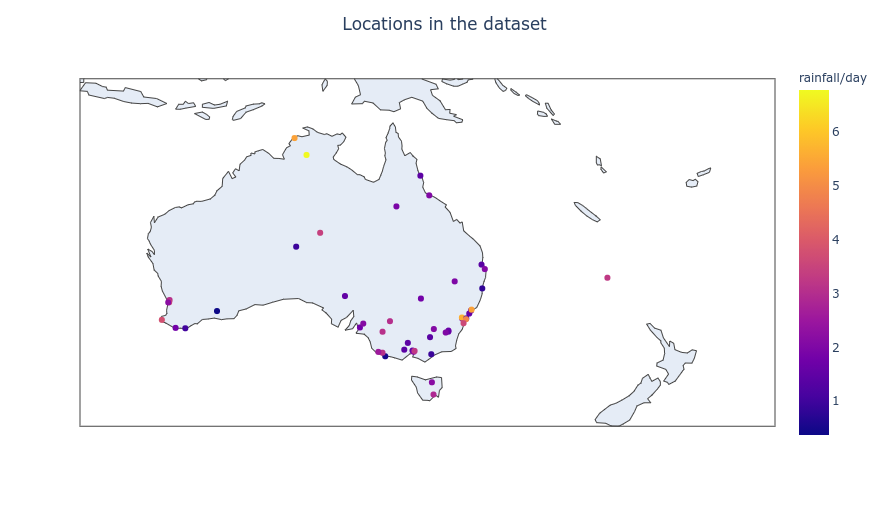

### Reorder columns

Put the date and coordinates columns into the beggining, and the target column at the end.

In [ ]:
# Reorder columns
initial_columns = ['year','month','day','latitude','longitude']
target_column = [TARGET_NAME]
middle_columns = [col for col in weather_df.columns if col not in initial_columns and col not in target_column]
columns_reordered = initial_columns + middle_columns + target_column

weather_df =  weather_df[columns_reordered]

### Proceed with data type conversion

In [ ]:
# Convert data types
weather_df = weather_df.convert_dtypes()

## Data Cleaning

### Remove rows with null values in the target column

If there's no value in the target column, we cannot use it into our training or test set. So we can remove those rows from the dataset.

In [ ]:
# There are null values (nan) in the RainTomorrow column
print("Before:\n  Unique values in the RainTomorrow column: ", weather_df.RainTomorrow.unique())
rows_before = len(weather_df)
print(" Total number of rows: [", rows_before, "]")
# Select only the not-null rows
weather_df = weather_df[weather_df.RainTomorrow.notna()]
print("\nAfter:\n  Unique values in the RainTomorrow column: ", weather_df.RainTomorrow.unique())
rows_after = len(weather_df)
print(" Total number of rows: [", rows_after, "] (", (rows_before-rows_after) , " rows removed )")

Before:
  Unique values in the RainTomorrow column:  <IntegerArray>
[0, 1, <NA>]
Length: 3, dtype: Int64
 Total number of rows: [ 145460 ]

After:
  Unique values in the RainTomorrow column:  <IntegerArray>
[0, 1]
Length: 2, dtype: Int64
 Total number of rows: [ 142193 ] ( 3267  rows removed )


### Ensure all data is float

It will help with the filling method later.

In [ ]:
for col in weather_df.columns:
  weather_df[col] = weather_df[col].astype('float32')

### Filling missing values 

In this step, we use the 'mean' strategy to fill the missing values of the features.

In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# transform the dataset
weather_df_transformed = pd.DataFrame(imputer.fit_transform(weather_df))
weather_df_transformed.columns = weather_df.columns
weather_df_transformed.index = weather_df.index

weather_df = weather_df_transformed

### Correlation

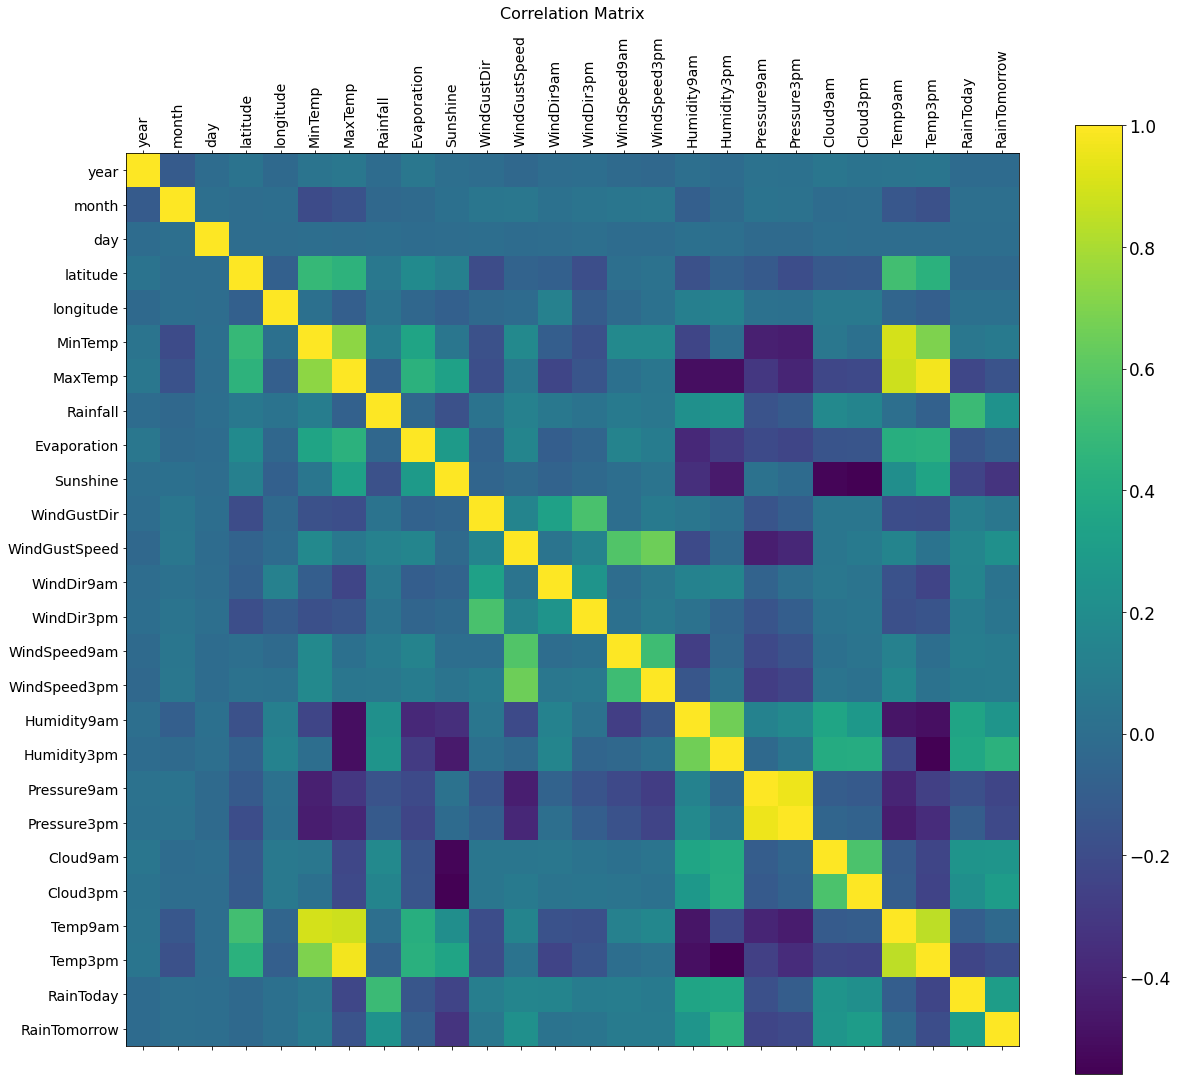

In [ ]:
f = plt.figure(figsize=(20, 17))
plt.matshow(weather_df.corr(), fignum=f.number)
plt.xticks(range(weather_df.select_dtypes(['number']).shape[1]), weather_df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(weather_df.select_dtypes(['number']).shape[1]), weather_df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=17)
plt.title('Correlation Matrix', fontsize=16, pad=90);

There are some correlation in the dataset. Enough to proceed with the work.

## Feature engineering

In [ ]:
values = weather_df.values

In [ ]:
# Number of features is the number of columns except the target column
NUM_FEATURES = len(weather_df.columns)-1
NUM_FEATURES

25

### Normalize features

The MinMaxScaler puts the values between 0 and 1, which further improves the model performance.

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)

### Split into input and outputs

X = features

Y = target

In [ ]:
target_col_idx = weather_df.columns.get_loc(TARGET_NAME)

X = values[:,0:target_col_idx].astype(float)
Y = values[:,target_col_idx]

print(X.shape,Y.shape)

(142193, 25) (142193,)


### Encode class values as integers

In [ ]:
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

## Design the model

We want to predict a boolean value ('Yes' or 'No') for the target variable **`RainTomorrow`**. In this case, we need to use a **classification** model, istead of a **regression** model, wich is used to predict real-world values (e.g. `Rainfall`).

In [ ]:
def create_model():
  model = Sequential(name='weather_guru')
  model.add(Dense(NEURONS_1, input_dim=NUM_FEATURES, activation='relu', name='dense_1'))
  model.add(Dense(NEURONS_2, activation='relu', name='dense_2'))
  model.add(Dense(1, activation='sigmoid', name='output'))
  adam_optmz = Adam(learning_rate=LEARNING_RATE)
  # Compile model
  model.compile(loss=LOSS_FUNCTION, optimizer=adam_optmz, metrics=['accuracy'])
  print(model.summary())
  return model

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn = create_model, epochs = EPOCHS, batch_size = BATCH_SIZE, verbose = 1)))
pipeline = Pipeline(estimators)

## Train the model and validate it

We use the cross validation score to measure the accuracy of our model.

In [ ]:
kfold = StratifiedKFold(n_splits=K_FOLD_SPLITS, shuffle=True)

The kfold will repeat the training `K_FOLD_SPLITS` times, selecting different sets of **train** and **test** data.

In [ ]:
%%time
results = cross_val_score(pipeline, X, encoded_Y, cv=kfold)

Model: "weather_guru"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 27)                702       
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 196       
_________________________________________________________________
output (Dense)               (None, 1)                 8         
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
112/112 [==============================] - 1s 2ms/step - loss: 0.5105 - accuracy: 0.7862
Epoch 2/100
112/112 [==============================] - 0s 1ms/step - loss: 0.3808 - accuracy: 0.8381
Epoch 3/100
112/112 [==============================] - 0s 2ms/step - loss: 0.3648 - accuracy: 0.8433
Epoch 4/100
112/112 [==============================] - 0s 2ms/step - loss: 0.3

## Final Results

In [ ]:
"Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100)

'Accuracy: 85.73% (0.12%)'

This is the final **result of model accuracy**, after cross-validation scoring.

If necessary, we can change the topology or model settings to try to achieve better accuracy values.
